In [1]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define a function to get the appropriate device
def get_device():
    """Selects the best available device for PyTorch computations.

    Returns:
        torch.device: The selected device.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

Using device: mps


In [3]:
import torch
import numpy as np
import normflows as nf

# Set up model

# Define flows
L = 2  # Reduced levels to match MNIST dimensions
K = 8  # Reduced blocks per level for simpler model
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1  # MNIST has single channel images
hidden_channels = 256
split_mode = 'channel'
scale = True

# Set up flows, distributions, and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                      split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]

# Construct flow model with the multiscale architecture
model1 = nf.MultiscaleFlow(q0, flows, merges)
model1 = model1.to(device)


/Users/parthathakuria/pytorch-test/env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2002.)
  LU, pivots, infos = torch._lu_with_info(


In [5]:
# Prepare training data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformation with resizing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', download=True, transform=transform)

# Print the total number of images in the dataset
print(f"Total number of images in the dataset: {len(dataset)}")

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

data_loader1 = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True)


Total number of images in the dataset: 60000


In [6]:
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

def train_model(model, train_loader, device, max_iter=5000, lr=1e-3, weight_decay=1e-5):
    """
    Train a normalizing flow model.

    Args:
        model: The normalizing flow model to be trained.
        train_loader: DataLoader for the training data.
        device: The device to perform training on (e.g., 'cuda', 'cpu').
        max_iter: Maximum number of iterations for training.
        lr: Learning rate for the optimizer.
        weight_decay: Weight decay for the optimizer.

    Returns:
        model: The trained model.
        loss_hist: Array of loss values over the training iterations.
    """
    
    # Initialize train_iter
    train_iter = iter(train_loader)

    # Initialize loss history
    loss_hist = np.array([])

    # Set up optimizer
    optimizer = torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    for i in tqdm(range(max_iter)):
        try:
            x, _ = next(train_iter)  # We ignore the labels
        except StopIteration:
            train_iter = iter(train_loader)
            x, _ = next(train_iter)  # We ignore the labels
        
        x = x.to(device)  # Move data to the same device as the model
        optimizer.zero_grad()
        loss = model.forward_kld(x)  # No labels passed
        
        if not (torch.isnan(loss) or torch.isinf(loss)):
            loss.backward()
            optimizer.step()

        loss_hist = np.append(loss_hist, loss.detach().cpu().numpy())
        del x, loss

    # Plot loss history
    plt.figure(figsize=(10, 10))
    plt.plot(loss_hist, label='loss')
    plt.legend()
    plt.show()

    return model


100%|███████████████████████████████████████| 5000/5000 [05:54<00:00, 14.09it/s]


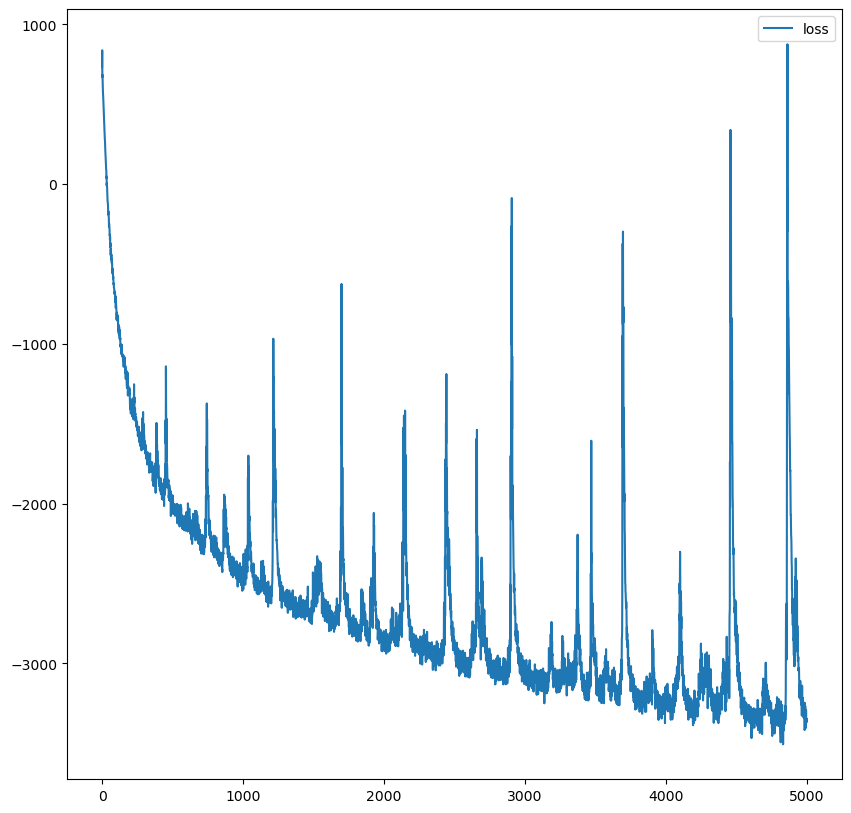

In [7]:
# Assuming `model`, `train_loader`, and `device` are already defined
model1 = train_model(model1, data_loader1, device)

In [24]:
import torch
from torch.utils.data import TensorDataset

# Load the sampled data
sampled_data_path = 'mnist_echo_cold_l1_alg2.pt'
sampled_data = torch.load(sampled_data_path)

# Extract the images from the dictionary
sampled_images = [sampled_data[key]['sampled'] for key in sampled_data]
sampled_images = torch.stack(sampled_images)  # Convert list to tensor

# Normalize the sampled images
sampled_images = sampled_images.float() / 255.0  # Scale back to [0, 1]
sampled_images = (sampled_images - 0.1307) / 0.3081  # Normalize using the same mean and std as MNIST

# Create labels for the sampled data (0 for generated images)
sampled_labels = torch.zeros(sampled_images.size(0), dtype=torch.long)

print(f"Loaded and normalized {sampled_images.size(0)} sampled images from {sampled_data_path}")

# Create a TensorDataset with the shuffled data
sampled_dataset = TensorDataset(sampled_images, sampled_labels)

data_loader2 = DataLoader(sampled_dataset, batch_size=64, shuffle=True)

Loaded and normalized 12000 sampled images from mnist_echo_cold_l1_alg2.pt


100%|███████████████████████████████████████| 5000/5000 [05:43<00:00, 14.57it/s]


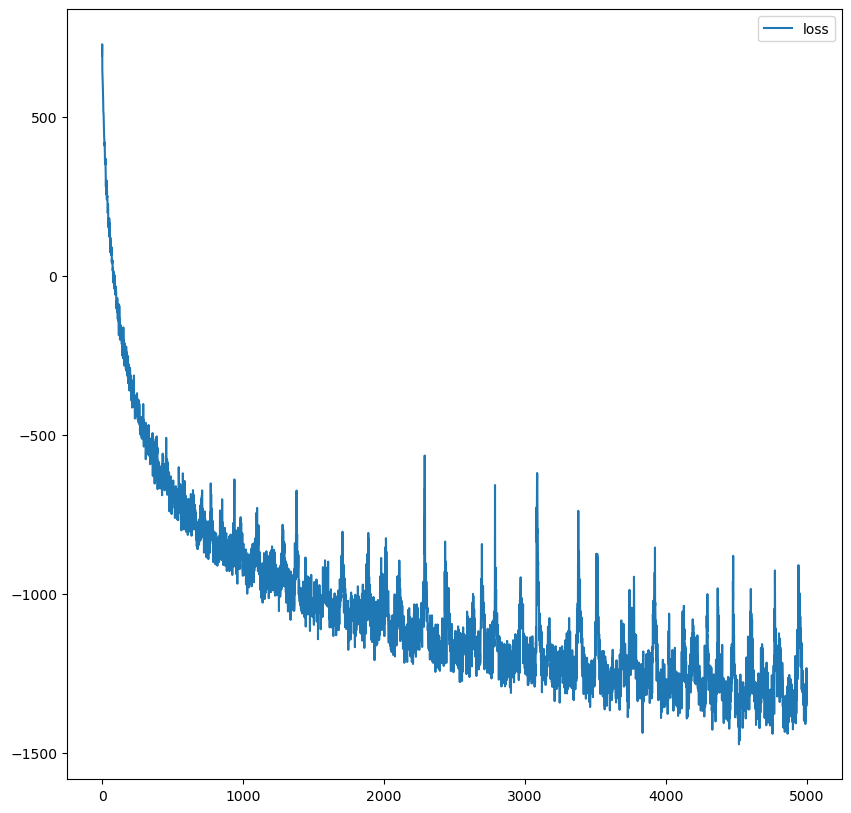

In [25]:
import torch
import numpy as np
import normflows as nf

# Set up model

# Define flows
L = 2  # Reduced levels to match MNIST dimensions
K = 8  # Reduced blocks per level for simpler model
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1  # MNIST has single channel images
hidden_channels = 256
split_mode = 'channel'
scale = True

# Set up flows, distributions, and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                      split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]

# Construct flow model with the multiscale architecture
model2 = nf.MultiscaleFlow(q0, flows, merges)
model2 = model2.to(device)

# Assuming `model`, `train_loader`, and `device` are already defined
model2 = train_model(model2, data_loader2, device, max_iter=5000, lr=1e-3, weight_decay=1e-5)

In [26]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def compute_kl_divergence(model1, model2, data_loader1, data_loader2):
    kl_divergence = 0.0
    num_samples = 0

    for x1, _ in data_loader1:
        x1 = x1.to(device)
        
        # Compute log probabilities under both models
        log_p_x1 = -model1.forward(x1)
        log_q_x1 = -model2.forward(x1)
        # Replace NaN or infinity values with zero
        log_p_x1[torch.isnan(log_p_x1) | torch.isinf(log_p_x1)] = 0
        log_q_x1[torch.isnan(log_q_x1) | torch.isinf(log_q_x1)] = 0

        # Accumulate KL divergence for data from X1
        kl_divergence += (log_p_x1 - log_q_x1).sum().item()
        num_samples += x1.size(0)

    for x2, _ in data_loader2:
        x2 = x2.to(device)
        
        # Compute log probabilities under both models
        log_p_x2 = -model1.forward(x2)
        log_q_x2 = -model2.forward(x2)

        # Replace NaN or infinity values with zero
        log_p_x2[torch.isnan(log_p_x2) | torch.isinf(log_p_x2)] = 0
        log_q_x2[torch.isnan(log_q_x2) | torch.isinf(log_q_x2)] = 0

        # Accumulate KL divergence for data from X2
        kl_divergence += (log_q_x2 - log_p_x2).sum().item()
        num_samples += x2.size(0)

    # Average KL divergence over the number of samples
    kl_divergence /= num_samples
    return kl_divergence

# Assuming `model1` and `model2` are your two trained models on datasets X1 and X2
# and `data_loader1` and `data_loader2` are your data loaders for the datasets X1 and X2
kl_div = compute_kl_divergence(model1, model2, data_loader1, data_loader2)
print(f"KL Divergence: {kl_div}")


KL Divergence: 6540.728119263184


In [27]:
import torch

def compute_kl_divergence(model1, model2, data_loader1, data_loader2):
    kl_divergence_pq = 0.0
    kl_divergence_qp = 0.0
    num_samples_p = 0
    num_samples_q = 0

    for x1, _ in data_loader1:
        x1 = x1.to(device)
        log_p_x1 = -model1.forward(x1, y=None)  # Use forward method to get negative log-likelihood
        log_q_x1 = -model2.forward(x1, y=None)  # Use forward method to get negative log-likelihood
        # Replace NaN or infinity values with zero
        log_p_x1[torch.isnan(log_p_x1) | torch.isinf(log_p_x1)] = 0
        log_q_x1[torch.isnan(log_q_x1) | torch.isinf(log_q_x1)] = 0
        kl_divergence_pq += (log_p_x1 - log_q_x1).sum().item()
        num_samples_p += x1.size(0)

    for x2, _ in data_loader2:
        x2 = x2.to(device)
        log_p_x2 = -model1.forward(x2, y=None)  # Use forward method to get negative log-likelihood
        log_q_x2 = -model2.forward(x2, y=None)  # Use forward method to get negative log-likelihood
        # Replace NaN or infinity values with zero
        log_p_x2[torch.isnan(log_p_x2) | torch.isinf(log_p_x2)] = 0
        log_q_x2[torch.isnan(log_q_x2) | torch.isinf(log_q_x2)] = 0
        kl_divergence_qp += (log_q_x2 - log_p_x2).sum().item()
        num_samples_q += x2.size(0)

    kl_divergence_pq /= num_samples_p
    kl_divergence_qp /= num_samples_q
    return kl_divergence_pq, kl_divergence_qp

# Assuming `model1` and `model2` are your two trained models on datasets X1 and X2
# and `data_loader1` and `data_loader2` are your data loaders for the datasets X1 and X2
kl_pq, kl_qp = compute_kl_divergence(model1, model2, data_loader1, data_loader2)
print(f"KL Divergence P(X1) || Q(X2): {kl_pq}")
print(f"KL Divergence Q(X2) || P(X1): {kl_qp}")


KL Divergence P(X1) || Q(X2): 5302.689019677473
KL Divergence Q(X2) || P(X1): 7775.588450520833


In [28]:
print(np.log(2))

0.6931471805599453


In [31]:
n_dims = 28*28
kl_divergences = [363, 1362, 1387, 4003, 7090]

for x in kl_divergences:
    kl_bits = (x)/ (n_dims*np.log(2))
    print(kl_bits)

0.6679825253095584
2.5063145990953677
2.5523189052461634
7.36620950086546
13.046821224365754
